In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [137]:
from patsy import dmatrices
from statsmodels.formula.api import glm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [138]:
data = pd.read_csv('/Users/elizabethmurphy/Downloads/empirical_shedding_data.csv')
data = data.iloc[:, :-3]
data.head()
# solid_frac = Fraction of solids in the sample
# extraction_mass_mg = Mass used for RNA extraction
# N_conc (gc/mg-dw) = Viral nucleocapsid gene concentration
# N_det = Detection of N gene
# ORF1a_conc (gc/gm-dw) = ORF1a gene concentration
# ORF1a_det = Detection of ORF1a
# PMMoV_conc (gc/mg-dw) = Pepper mild mottle virus concentration
# PMMoV_det = Detection of PMMoV
# crAss_conc = crAssphage concentration
# crAss_quant = ?
# crAss_det = Detection of crAssphage

,ID,Day,solid_frac,extraction_mass_mg,N_conc (gc/mg-dw),N_det,ORF1a_conc (gc/gm-dw),ORF1a_det,PMMoV_conc (gc/mg-dw),PMMoV_det,crAss_conc,crAss_quant,crAss_det
0,4512,5,0.094133,11.5,1189.808219,True,3768.957713,True,NaN,False,1.054633e+07,True,True
1,4512,6,0.228228,17.5,649.722988,True,282.820595,True,175.807397,True,1.642356e+07,True,True
2,4512,7,0.187342,14.4,1203.595506,True,418.172285,True,941.273408,True,1.189325e+08,True,True
3,4514,13,0.135564,19.9,39.322095,False,39.322095,False,84.219268,False,2.540387e+02,False,True
4,4514,15,0.130321,16.7,59.181158,False,59.181158,True,771.928144,True,1.698420e+02,False,True


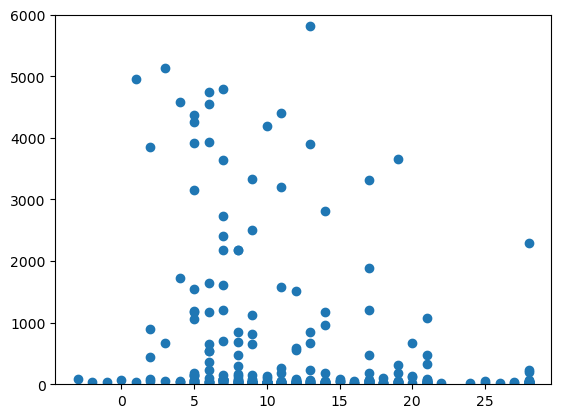

In [139]:
# plot shedding curve, not including outliers. 
fig,ax = plt.subplots()
ax.scatter(data['Day'],data['N_conc (gc/mg-dw)'])
ax.set_ylim([0,6000])
plt.show()

In [140]:
data['N_conc'] = data['N_conc (gc/mg-dw)']*data['N_det']
data['N_conc'] = pd.to_numeric(data['N_conc'], errors='coerce')
# Remove outliers
data = data[data['N_conc'] < data['N_conc'].quantile(0.95)]

In [141]:
expr = " N_conc ~ Day + I(Day**2) + I(Day**3)"
y, X = dmatrices(expr, data, return_type='dataframe')
model = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 N_conc   No. Observations:                  358
Model:                            GLM   Df Residuals:                      354
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3700.8
Date:                Wed, 25 Jun 2025   Deviance:                       4258.7
Time:                        11:11:40   Pearson chi2:                 2.96e+03
No. Iterations:                    16   Pseudo R-squ. (CS):             0.1025
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       9.7395      0.230     42.371      0.000       9.289      10.190
Day            -0.2240      0.060     -3.703      0.000      -0.343      -0.105
I(Day ** 2)     0.0248      0.005      5.151      0.000       0.015       0.034
I(Day ** 3)    -0.0007      0.000     -6.089      0.000      -0.001      -0.000
===============================================================================
"""

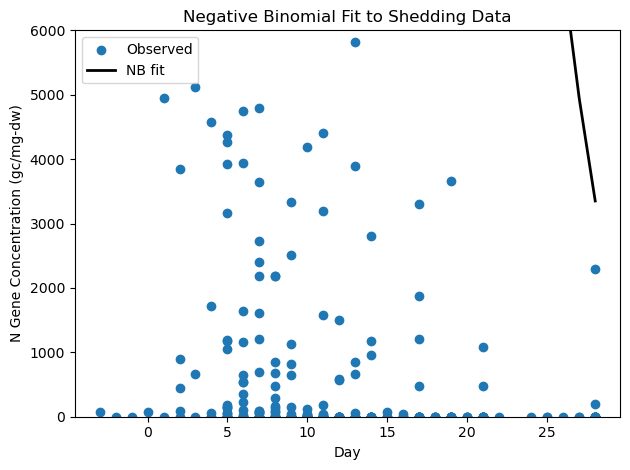

In [ ]:
# Predict fitted values
data['fit'] = results.predict(X)

# Compute mean fitted value per day
mean_fit = data.groupby('Day')['fit'].mean().reset_index().sort_values('Day')

fig,ax = plt.subplots()
ax.scatter(data['Day'], data['N_conc'], label='Observed')
ax.plot(mean_fit['Day'], mean_fit['fit'], color='black', linewidth=2, label='NB fit')
ax.set_ylim([0, 6000])
ax.set_xlabel("Day")
ax.set_ylabel("N Gene Concentration (gc/mg-dw)")
ax.set_title("Negative Binomial Fit to Shedding Data")
ax.legend()
plt.tight_layout()
plt.show()